In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks, set_color
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = {
    # E membrane dynamics
    'C_M_E': 0.5e-9, 'G_L_E': 10e-9, 'E_L_E': -0.05, 'V_TH_E': -0.036, 'V_R_E': -0.05, 'T_R_E': 0.008,
    # E architecture
    'N_E': 3000, 'W_E_E': .026e-6, 'L_E_E': 0.03, 'W_MIN_E_E': 0.001e-6,
    
    # I membrane dynamics
    'C_M_I': .05e-9, 'G_L_I': 10e-9, 'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    # I architecture
    'N_I': 150, 'W_I_E': 0.005e-7, 'W_E_I': 0.001e-6,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
}

## SMLN
S = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": .5, "BOX_W": 8, "X_TRG": 1, "Y_TRG": -0.75,
    
    'TRG': [
        {'T': 0.15, 'A': 0.01e-6, 'R': 0.15, 'D': 0.002, 'X': -4, 'Y': 0},
    ],
    
    'D_SMLN': 1,
}

In [2]:
# connectivity funcs
def apx_lattice(lb, ub, n, randomize):
    """
    Arrange n points on an apx. lattice within a rectangle.
    (Apx. b/c rectangle dims may not evenly divide n.)
    """
    lb_x, lb_y = lb
    ub_x, ub_y = ub

    r_x = ub_x - lb_x
    r_y = ub_y - lb_y

    # get apx factors of n
    n_x = np.sqrt((r_x/r_y) * n)
    n_y = n/n_x

    # get # pts per row
    n_rows = int(np.round(n_y))
    n_pts = [len(row) for row in np.array_split(np.arange(n), n_rows)]

    # evenly distribute n_pts so that largest rows are not clumped at top
    if len(set(n_pts)) > 1:
        
        ## split into groups of same n_pts
        gp_0, gp_1 = [[ii for ii in n_pts if ii == i] for i in set(n_pts)]

        if len(gp_1) > len(gp_0):
            gp_0, gp_1 = gp_1, gp_0

        ## assign float "t" to each n_pt
        n_0 = len(gp_0)
        n_1 = len(gp_1)

        ts_0 = [k * (n - 1) / (n_0 - 1) for k in range(n_0)]
        ts_1 = [k * (n - 1) / (n_1 + 1) for k in range(1, n_1 + 1)]

        ts = cc([ts_0, ts_1])

        ## sort n_pts according to ts
        n_pts = cc([gp_0, gp_1])[np.argsort(ts)]
    
    # assign (x, y) positions
    ys_row = np.linspace(lb_y, ub_y, n_rows+2)[1:-1]

    xs = []
    ys = []

    ## add group of positions for each row
    for y_row, n_pts_ in zip(ys_row, n_pts):
        xs_ = list(np.linspace(lb_x, ub_x, n_pts_ + 2)[1:-1])
        ys_ = list(np.repeat(y_row, len(xs_)))

        xs.extend(xs_)
        ys.extend(ys_)
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    if randomize:
        shuffle = np.random.permutation(n)
        
        xs = xs[shuffle]
        ys = ys[shuffle]

    return xs, ys


def make_w_e_e(pfxs, pfys, m):
    """Make E-E weight mat w/ weight increasing w/ proxim."""
    n_e = m['N_E']
    
    # build distance matrix
    dx = np.tile(pfxs[None, :], (n_e, 1)) - np.tile(pfxs[:, None], (1, n_e))
    
    # build weight matrix
    ## decrease weights as squared exp of dist
    w = m['W_E_E'] * np.exp(-dx**2/(2*m['L_E_E']**2))
    ## set all weights below min weight th to 0
    w[w < m['W_MIN_E_E']] = 0
    
    return w
    

def make_w_i_e(pfxs_i, pfys_i, pfxs_e, pfys_e, m):
    """
    Make proximally biased E->I weight matrix.
    """
    n_i = m['N_I']
    n_e = m['N_E']
    
    # build weight matrix
    w_i_e = m['W_I_E'] * (np.random.rand(n_i, n_e) < 0.5).astype(float)
    return w_i_e
    
    
def make_w_e_i(pfxs_e, pfys_e, pfxs_i, pfys_i, m):
    """
    Make center-surround structured I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < 0.5).astype(float)
    return w_e_i

In [3]:
# smln funcs
def smln_run(m, s):
    """
    Run smln and return rslt.
    """
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s)
   
    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    return rslt


def build_ntwk(m, s):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s['RNG_SEED'])
    
    # set membrane properties
    n = m['N_E'] + m['N_I']
    
    c_m = cc(
        [np.repeat(m['C_M_E'], m['N_E']), np.repeat(m['C_M_I'], m['N_I'])])
    g_l = cc(
        [np.repeat(m['G_L_E'], m['N_E']), np.repeat(m['G_L_I'], m['N_I'])])
    e_l = cc(
        [np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])
    v_th = cc(
        [np.repeat(m['V_TH_E'], m['N_E']), np.repeat(m['V_TH_I'], m['N_I'])])
    v_r = cc(
        [np.repeat(m['V_R_E'], m['N_E']), np.repeat(m['V_R_I'], m['N_I'])])
    t_rp = cc(
        [np.repeat(m['T_R_E'], m['N_E']), np.repeat(m['T_R_I'], m['N_I'])])
    
    # set latent nrn positions
    lb = [-s['BOX_W']/2, -s['BOX_H']/2]
    ub = [s['BOX_W']/2, s['BOX_H']/2]
    
    # sample evenly spaced place fields for E and I cells
    pfxs_e, pfys_e = apx_lattice(lb, ub, m['N_E'], randomize=True)
    pfxs_i, pfys_i = apx_lattice(lb, ub, m['N_I'], randomize=True)
    
    ## join E & I place fields
    pfxs = cc([pfxs_e, pfxs_i])
    pfys = np.zeros(m['N_E'] + m['N_I'])  #cc([pfys_e, pfys_i])
       
    w_u = {'E': np.zeros((m['N_E'] + m['N_I'], 0))}
    
    # make rcr ws
    w_e_e = make_w_e_e(pfxs[:m['N_E']], pfys[:m['N_E']], m)

    w_i_e = make_w_i_e(
        pfxs_i=pfxs[-m['N_I']:],
        pfys_i=pfys[-m['N_I']:],
        pfxs_e=pfxs[:m['N_E']],
        pfys_e=pfys[:m['N_E']],
        m=m)
    
    w_e_i = make_w_e_i(
        pfxs_e=pfxs[:m['N_E']],
        pfys_e=pfys[:m['N_E']],
        pfxs_i=pfxs[-m['N_I']:],
        pfys_i=pfys[-m['N_I']:],
        m=m)
    
    w_r_temp = {
        'E': {
            ('E', 'E'): w_e_e,
            ('I', 'E'): w_i_e,
        },
        'I': {
            ('E', 'I'): w_e_i,
        },
    }
    targs_rcr = cc([np.repeat('E', m['N_E']), np.repeat('I', m['N_I'])])
    
    w_r = join_w(targs_rcr, targs_rcr, w_r_temp)
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m, g_l=g_l, e_l=e_l, v_th=v_th, v_r=v_r, t_r=t_rp,
        e_s={'E': m['E_E'], 'I': m['E_I']}, t_s={'E': m['T_E'], 'I': m['T_I']},
        w_r=w_r, w_u=w_u)
    
    ntwk.pfxs = pfxs
    ntwk.pfys = pfys
    
    ntwk.types_rcr = targs_rcr
    
    ntwk.n_e = m['N_E']
    ntwk.n_i = m['N_I']
    ntwk.n = m['N_E'] + m['N_I']
    
    ntwk.types_rcr_slc = {
        'E': slice(0, m['N_E']),
        'I': slice(m['N_E'], m['N_E'] + m['N_I'])
    }
    
    return ntwk


def i_ext_trg(t, ntwk, m, s):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # get mask over cells to trigger to induce replay
    for trg in s['TRG']:
        
        ## compute distances to trigger center
        dx = ntwk.pfxs - trg['X']
        dy = ntwk.pfys - trg['Y']
        d = np.sqrt(dx**2 + dy**2)

        ## get mask
        trg_mask = (d < trg['R']) & (ntwk.types_rcr == 'E')

        ## get time mask
        t_mask = (trg['T'] <= t) \
            & (t < (trg['T'] + trg['D']))

        ## add in external trigger
        i_ext[np.outer(t_mask, trg_mask)] = trg['A']

    return i_ext

In [4]:
# run smln
m = copy(M)
s = copy(S)

s['RNG_SEED'] = 0

print('Running smln...')
rslt = smln_run(m, s)
print('Smln complete.')

Running smln...
Smln complete.


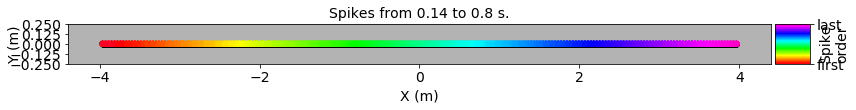

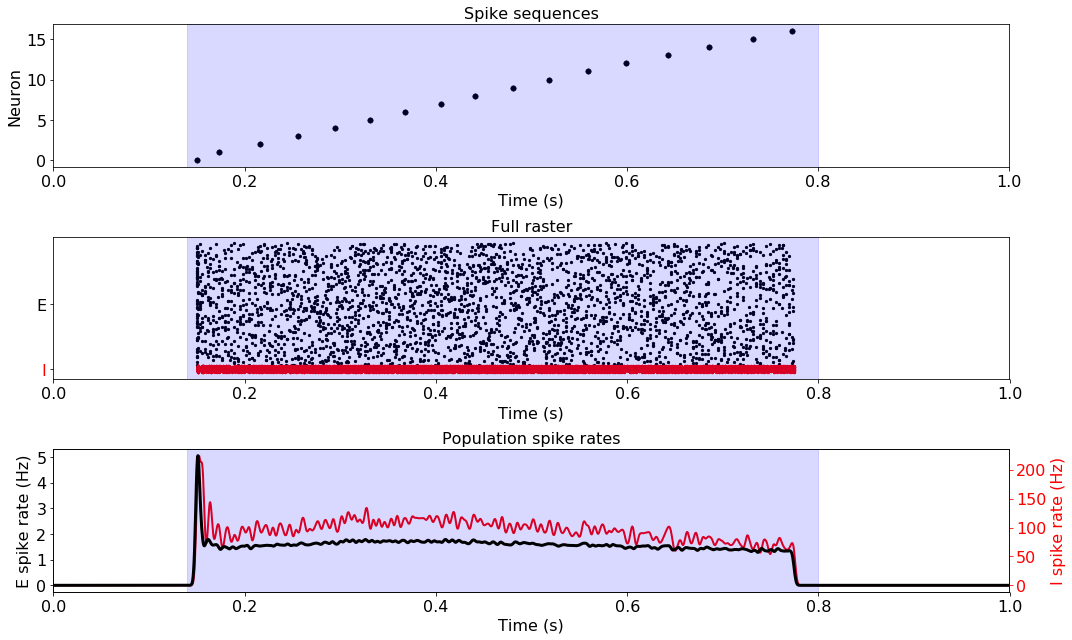

In [5]:
# make plots
XYS_RASTER = [
    (-4, 0), (-3.5, 0), (-3, 0), (-2.5, 0),
    (-2, 0), (-1.5, 0), (-1, 0), (-.5, 0), (0, 0), (.5, 0), (1, 0), (1.5, 0), (2, 0),
    (2.5, 0), (3, 0), (3.5, 0), (4, 0),
]
EPOCH = (.14, .8)

# plot funcs
def get_idxs_nearest(xys, pfxs, pfys, nearest):
    """
    Get ordered idxs of place fields nearest to a
    sequence of (x, y) points.
    """
    idxs = []
    
    for xy in xys:
        # get dists of all PFs to (x, y)
        dx = pfxs - xy[0]
        dy = pfys - xy[1]
        d = np.sqrt(dx**2 + dy**2)
        
        # add idxs of closest neurons to list
        idxs_ = list(d.argsort()[:nearest])
        idxs.extend(idxs_)
        
    return idxs


epoch = EPOCH
cmap='gist_rainbow'
sct_sz=25

fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

## detection wdw
start = epoch[0]
end = epoch[1]

t_mask = (start <= rslt.t) & (rslt.t < end)

## E mask and PFs
e_mask = rslt.ntwk.types_rcr == 'E'

pfxs_e = rslt.ntwk.pfxs[e_mask]
pfys_e = rslt.ntwk.pfys[e_mask]

## E spk cts within detection window
spks_wdw_e = rslt.spks[t_mask][:, e_mask]
spk_ct_wdw_e = spks_wdw_e.sum(0)

## discrete colormap for showing spk cts
c_map_tmp = plt.cm.jet
c_map_list = [c_map_tmp(i) for i in range(c_map_tmp.N)]
c_map_list[0] = (0., 0., 0., 1.)
c_map = c_map_tmp.from_list('spk_ct', c_map_list, c_map_tmp.N)

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, c_map.N)

# E spiking order
if not np.any(spk_ct_wdw_e):

    raise Exception('No spks')

## black bkgd for all Es
ax.scatter(pfxs_e, pfys_e, c='k', s=25, zorder=-1)

## color Es according to timing of first spike
spk_mask = spk_ct_wdw_e > 0
spk_order = np.argmax(spks_wdw_e[:, spk_mask], 0)
spk_order = np.argsort(spk_order).argsort()

v_min = spk_order.min()
v_max = spk_order.max()

im = ax.scatter(
    pfxs_e[spk_mask], pfys_e[spk_mask], c=spk_order, s=sct_sz,
    vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

divider = make_axes_locatable(ax)
c_ax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=c_ax, ticks=[v_min, v_max])
cb.set_ticklabels(['first', 'last'])

ax.set_aspect('equal')

set_n_x_ticks(ax, 5, -rslt.s['BOX_W']/2, rslt.s['BOX_W']/2)
set_n_y_ticks(ax, 5, -rslt.s['BOX_H']/2, rslt.s['BOX_H']/2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)', labelpad=-12)
c_ax.set_ylabel('Spike\norder', labelpad=-25)
ax.set_title('Spikes from {} to {} s.'.format(*epoch))

for ax_ in [ax, cb.ax]:
    set_font_size(ax_, 14)

ax.set_facecolor((.7, .7, .7))


xys = XYS_RASTER
colors=np.zeros(len(XYS_RASTER))
cmap='inferno'
nearest=1
epoch=(0, 1)
trg_plt=[]
#y_lim=(-1, 9)
#y_ticks=[0, 3, 6, 9, 12]
smoothness=4
fig_size=(15, 9)

fig, axs = plt.subplots(3, 1, figsize=fig_size, tight_layout=True)

# get ordered idxs of Es to plot
## get pfs
e_mask = rslt.ntwk.types_rcr == 'E'
pfxs = rslt.ntwk.pfxs[e_mask]
pfys = rslt.ntwk.pfys[e_mask]

## loop through (x, y) pairs and add idxs of nearest Es
e_idxs = get_idxs_nearest(xys, pfxs, pfys, nearest) 

# get all spks for selected Es
spks_e_chosen = rslt.spks[:, e_idxs]

# get desired time window
if epoch == 'replay':
    start = 0
    end = rslt.schedule['D_SMLN']
elif isinstance(epoch, tuple):
    start = epoch[0]
    end = epoch[1]

t_mask = (start <= rslt.t) & (rslt.t < end)
t_start = rslt.t[t_mask][0]

spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
spk_ts = spk_t_idxs * rslt.s['DT'] + t_start

## spks
axs[0].scatter(spk_ts, es, c='k', s=30, vmin=0, vmax=1, cmap=cmap, lw=.5, edgecolor='k')

## replay trigger
for trg, (y, marker) in zip(rslt.trg, trg_plt):
    axs[0].scatter(trg['T'], y, marker=marker, s=100, c='k')

axs[0].set_xlim(start, end)
#axs[0].set_ylim(y_lim)
#axs[0].set_yticks(y_ticks)

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Neuron')
axs[0].set_title('Spike sequences')

set_font_size(axs[0], 16)

# Es
## get spks
spks_e = rslt.spks[:, :rslt.m['N_E']]

## raster
t_idxs_spks_e, nrn_spks_e = spks_e.nonzero()
t_spks_e = t_idxs_spks_e * rslt.dt

axs[1].scatter(t_spks_e, nrn_spks_e, s=5, c='k')

# population firing rate
axs[2].plot(rslt.t, smooth(spks_e.sum(axis=1) / (rslt.dt * rslt.m['N_E']), smoothness), c='k', lw=3)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('E spike rate (Hz)')
axs[2].set_title('Population spike rates')

# Is
# get spks
spks_i = rslt.spks[:, -rslt.m['N_I']:]

# raster
t_idxs_spks_i, nrn_spks_i = spks_i.nonzero()
t_spks_i = t_idxs_spks_i * rslt.dt

axs[1].scatter(t_spks_i, -(1 + nrn_spks_i), s=5, c='r')
axs[1].set_yticks([-rslt.m['N_I']/2, rslt.m['N_E']/2])
axs[1].set_yticklabels(['I', 'E'])
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Full raster')

for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
    tick_label.set_color(color)

# inh population average
ax_2_twin = axs[2].twinx()
ax_2_twin.plot(rslt.t, smooth(spks_i.sum(axis=1) / (rslt.dt * rslt.m['N_I']), smoothness), c='r', lw=2)
ax_2_twin.set_ylabel('I spike rate (Hz)')

axs[2].set_zorder(ax_2_twin.get_zorder() + 1)
axs[2].patch.set_visible(False)

set_color(ax_2_twin, 'r')

for ax in list(axs[1:]) + [ax_2_twin]:
    ax.set_xlim(0, rslt.t[-1])
    set_font_size(ax, 16)
    
axs[0].axvspan(*EPOCH, color='b', alpha=0.15)
axs[1].axvspan(*EPOCH, color='b', alpha=0.15)
axs[2].axvspan(*EPOCH, color='b', alpha=0.15);